In [1]:
# increase the usability of matplotlib in Jupyter Notebooks 
%matplotlib notebook             

from IG_scheduling import * # import module to perform interval graph scheduling similar to melon paper

In [2]:
## Settings for this run
n_arm  = 1 
n_cell = 1

one_arm = IG_scheduling(n_arm, n_cell)

In [3]:
one_arm.initDummyNodes()
one_arm.initBaseTimeIntervals()
print()
one_arm.chooseArm4Fruit()

In [4]:
one_arm.calcResults()

Total number of fruit: 189
Vehicle velocity: 0.08 m/s
Number of rows: 1
Number of arms in row: 1

Total harvested fruit: 23
FPE = fruit picked / total fruit:           0.12169312169312169
FPT = total fruit / total vehicle run time: 0.184 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 23 


In [5]:
fruit_picked_by_one_arm = one_arm.fruitPickedBy()
# one_arm.calculateStateTimePercent(fruit_picked_by_one_arm)

[[[7, 15, 23, 27, 35, 45, 57, 64, 69, 77, 86, 95, 104, 110, 117, 123, 129, 137, 145, 154, 159, 171, 175], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]]]


In [6]:
## Multiple runs checking one arm results vs multiple arm results - FPT_N_arms / (N*FPT_onearm)
final_cells = 3  # total final number of rows being analyzed
final_arms  = 3  # total final number of arms per row being analyzed

FPT_results = np.zeros([final_cells, final_arms])
FPE_results = np.zeros([final_cells, final_arms])

for rows in range(1,final_cells+1):
    for arms in range(1,final_arms+1):
        total_arms = rows * arms
        
        multi_arm = IG_scheduling(arms, rows)
        multi_arm.initDummyNodes()
        multi_arm.initBaseTimeIntervals()
        multi_arm.chooseArm4Fruit()
        multi_arm.calcResults()
        print('----------------------------------------------------------')
        print()
        
        FPT_analysis = multi_arm.FPT / (total_arms*one_arm.FPT)
        FPE_analysis = multi_arm.FPE / (total_arms*one_arm.FPE)
        
        FPT_results[rows-1, arms-1] = FPT_analysis 
        FPE_results[rows-1, arms-1] = FPE_analysis 
        


print()
print('----------------------------------------------------------')
print('----------------------------------------------------------')
print('FPT:', FPT_results)
print('FPE:', FPE_results)

Total number of fruit: 189
Vehicle velocity: 0.08 m/s
Number of rows: 1
Number of arms in row: 1

Total harvested fruit: 23
FPE = fruit picked / total fruit:           0.12169312169312169
FPT = total fruit / total vehicle run time: 0.184 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 23 
----------------------------------------------------------

Total number of fruit: 189
Vehicle velocity: 0.08 m/s
Number of rows: 1
Number of arms in row: 2

Total harvested fruit: 43
FPE = fruit picked / total fruit:           0.2275132275132275
FPT = total fruit / total vehicle run time: 0.344 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 23  arm 1: 20 
----------------------------------------------------------

Total number of fruit: 189
Vehicle velocity: 0.08 m/s
Number of rows: 1
Number of arms in row: 3

Total harvested fruit: 61
FPE = fruit picked / total fruit:           0.32275132275132273
FPT = total fruit / total vehicle run time: 0.488 fruit/sec

Number of fruit picked by

<IPython.core.display.Javascript object>


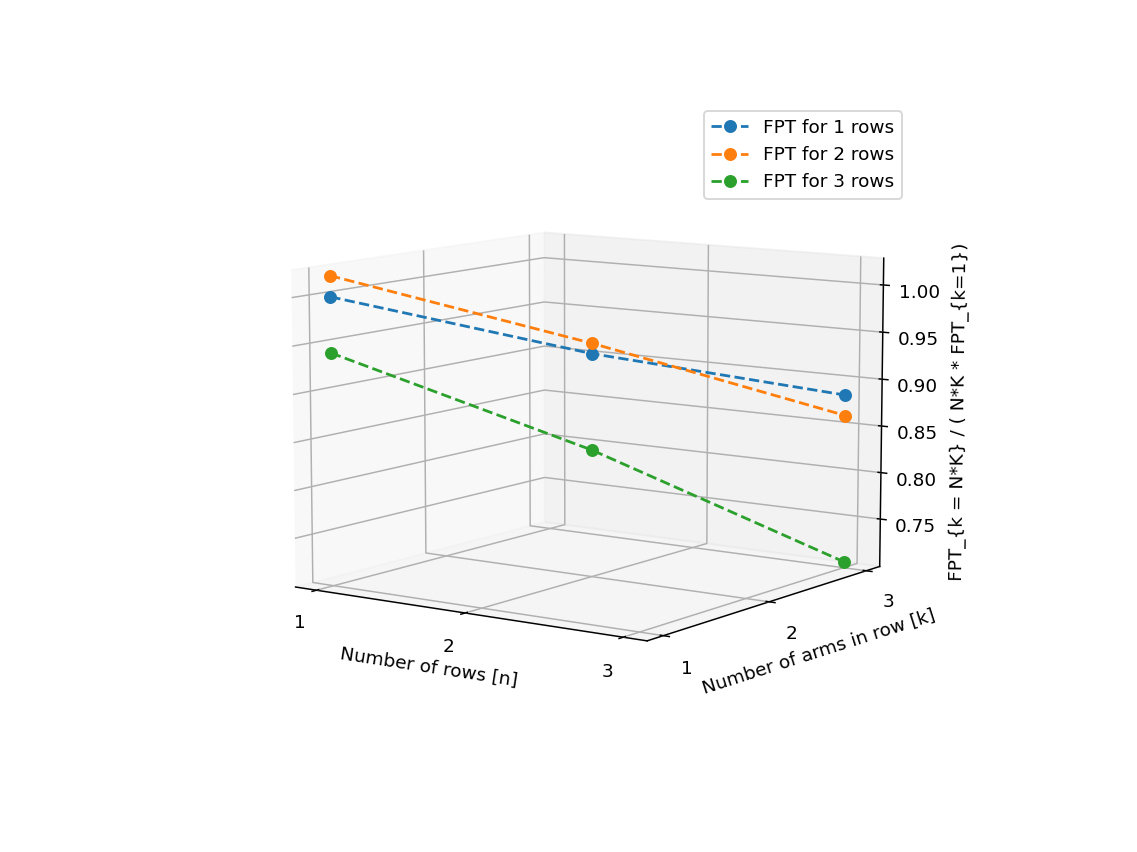

In [27]:
'''Analyze the results comparing one arm versus multiple arms'''
fig = plt.figure()
ax = plt.axes(projection ='3d')

x_axis = np.linspace(1, final_cells, final_cells, endpoint=True)
y_axis = np.linspace(1, final_arms, final_arms, endpoint=True)

for n in range(final_cells):
    FPT_label = 'FPT for ' + str(n+1) + ' rows'
#     FPE_label = 'FPE for ' + str(n+1) + ' rows'
    
    plt.plot(x_axis, 
             y_axis,
             FPT_results[n], 'o--', label=FPT_label)
    
#     plt.plot(x_axis, 
#              y_axis,
#              FPE_results[n], 'x-', label=FPE_label)


legend = ax.legend(loc='upper right')

plt.xticks(x_axis)
plt.yticks(y_axis)
                   
ax.set_xlabel('Number of rows [n]')
ax.set_ylabel('Number of arms in row [k]')
ax.set_zlabel('FPT_{k = N*K} / ( N*K * FPT_{k=1})')

plt.show()

<IPython.core.display.Javascript object>


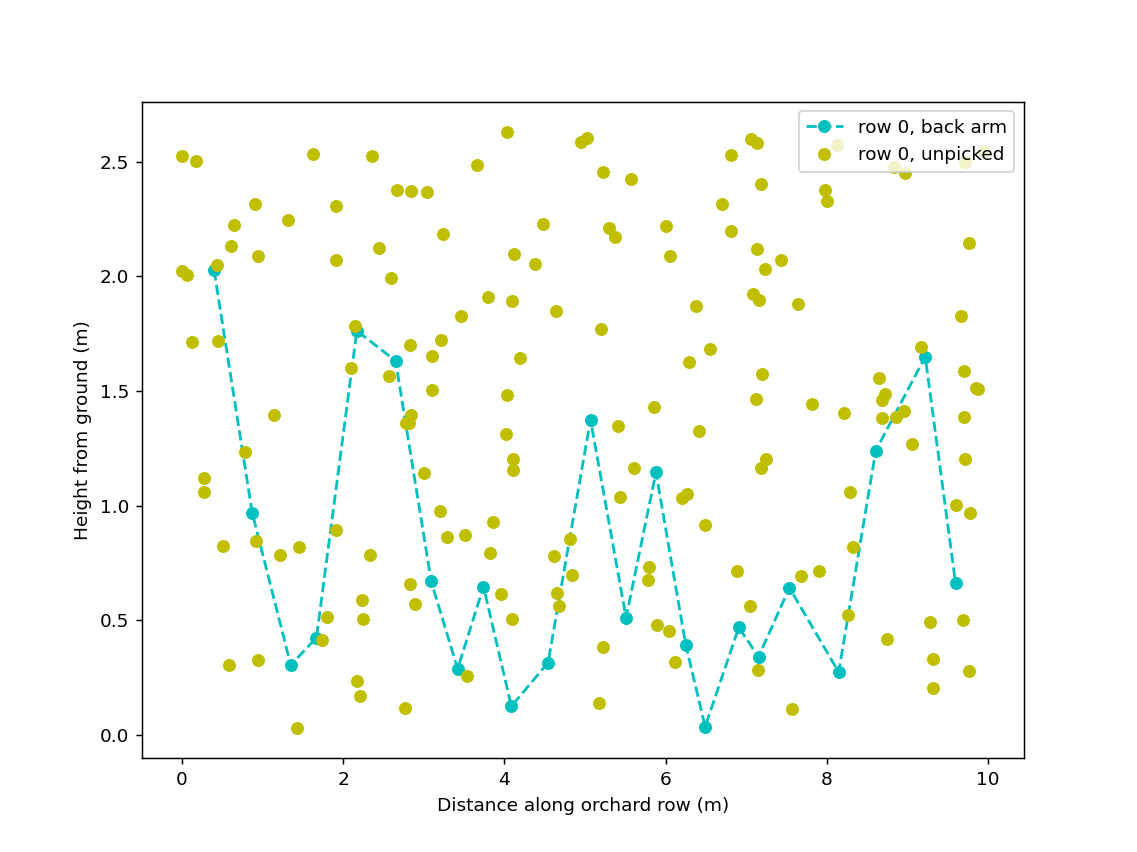

In [9]:
# melon_sched.plot2DSchedule(fruit_picked_by)

<IPython.core.display.Javascript object>


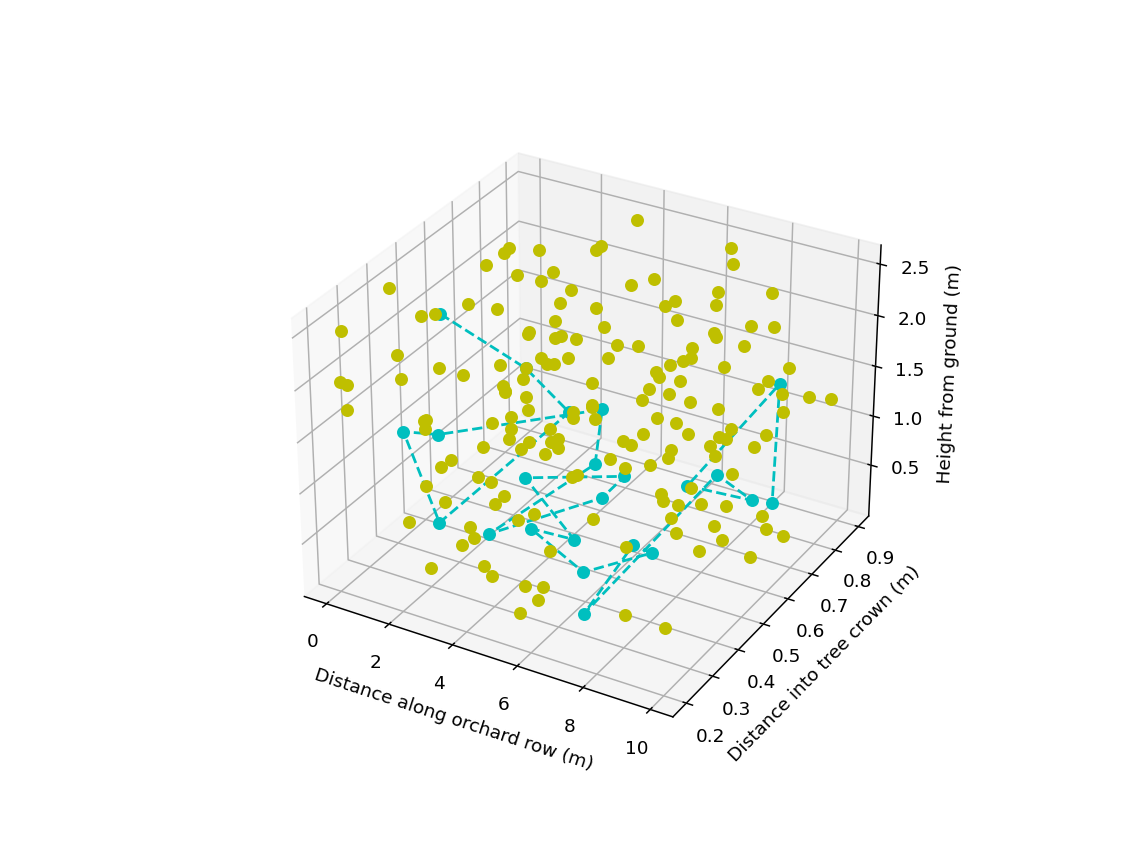

In [10]:
# melon_sched.plot3DSchedule(fruit_picked_by)

In [ ]:
# '''Plot the intervals -- Testing time not distance intervals'''
# # based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# # plot is based on time...
# fig, ax = plt.subplots()

# for e in IG.edges():
#     if e[1].k == 0:
#         intervalGraph(e[1].k, e[2], e[3], color='c')
#     elif e[1].k == 1:
#         intervalGraph(e[1].k, e[2], e[3], color='r')
#     elif e[1].k == 2:
#         intervalGraph(e[1].k, e[2], e[3], color='b')

# plt.xlabel('Time (sec)')
# plt.ylabel('Arm number')
        
# plt.show()